In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/rashikrahmanpritom/plant-disease-recognition-dataset


In [2]:
import tensorflow as tf
import numpy as np
import os

2026-02-18 18:19:43.480114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771438783.698236      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771438783.759430      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771438784.296650      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771438784.296703      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771438784.296707      23 computation_placer.cc:177] computation placer alr

In [3]:
train_path='/kaggle/input/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/Train/Train'
# val_path='/kaggle/input/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/Validation/Validation'

IMG_SIZE=260
BATCH_SIZE=32

train_ds=tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds=tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

num_classes=train_ds.class_names
print(num_classes)

Found 1322 files belonging to 3 classes.
Using 1058 files for training.


I0000 00:00:1771438804.483933      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1322 files belonging to 3 classes.
Using 264 files for validation.
['Healthy', 'Powdery', 'Rust']


In [4]:
for x, y in train_ds.take(1):
    print(y[0])

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


In [5]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(32, 260, 260, 3)
(32, 3)


In [6]:
# from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers,models

In [7]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

train_ds=train_ds.map(lambda x, y:(data_augmentation(x),y),
                     num_parallel_calls=tf.data.AUTOTUNE
                     )

In [8]:
normalization_layer=tf.keras.layers.Rescaling(1./255)
train_ds=train_ds.map(lambda x, y:(normalization_layer(x),y),
                     num_parallel_calls=tf.data.AUTOTUNE
                     ).prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.map(lambda x, y:(normalization_layer(x),y),
                 num_parallel_calls=tf.data.AUTOTUNE
                 ).prefetch(tf.data.AUTOTUNE)

In [9]:
for image, label in train_ds.take(1):
    print('min:',tf.reduce_min(image).numpy())
    print('max:',tf.reduce_max(image).numpy())

for x,y in val_ds.take(1):
    print('val_min:',tf.reduce_min(x).numpy())
    print('val_max:',tf.reduce_max(x).numpy())

min: 0.0
max: 1.0
val_min: 0.0
val_max: 1.0


In [10]:
from tensorflow.keras.applications import EfficientNetB2

In [11]:
base_model=EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)
base_model.trainabal=False
print(base_model.trainabal)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
False


In [12]:
inputs=tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x=base_model(inputs, training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.5)(x)

outputs=layers.Dense(3, activation='softmax')(x)

model=tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 9, 9, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         4,227 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,778,428 (29.67 MB)

 Trainable params: 7,708,037 (29.40 MB)

 Non-trainable params: 70,391 (274.97 KB)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
    )
]

In [16]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

Epoch 1/15


I0000 00:00:1771438877.471038      72 service.cc:152] XLA service 0x7ec124023e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771438877.471102      72 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771438892.486777      72 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-18 18:21:53.034190: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-18 18:21:53.227364: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-18 18:21:53.794472: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accur

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5088 - loss: 1.3335

2026-02-18 18:23:28.540561: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-18 18:23:28.728498: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-18 18:23:29.162418: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-18 18:23:29.372316: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/34 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5162 - loss: 1.3131 - val_accuracy: 0.3371 - val_loss: 1.1124
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 918ms/step - accuracy: 0.8568 - loss: 0.4049 - val_accuracy: 0.3371 - val_loss: 1.1455
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 912ms/step - accuracy: 0.8947 - loss: 0.2793 - val_accuracy: 0.3523 - val_loss: 1.1003
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 917ms/step - accuracy: 0.9231 - loss: 0.2197 - val_accuracy: 0.3220 - val_loss: 1.1053
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 942ms/step - accuracy: 0.9520 - loss: 0.1830 - val_accuracy: 0.3447 - val_loss: 1.1010
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 915ms/step - accuracy: 0.9652 - loss: 0.0979 - val_accuracy: 0.3636 - val_loss: 1.0861
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 882ms/step - accuracy: 0.9778 - loss: 0.0669 - val_accuracy: 0.4015 - val_loss: 1.0853
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 908ms/step - accuracy: 0.9861 - loss: 0.0563 - val_accuracy: 0.5114 

In [17]:
base_model.trainable=True
for layer in base_model.layers[:-30]:
    layers.trainable=False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    verbose=1
)

Epoch 1/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9826 - loss: 0.0410 - val_accuracy: 0.6326 - val_loss: 0.8946
Epoch 2/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 905ms/step - accuracy: 0.9897 - loss: 0.0318 - val_accuracy: 0.8674 - val_loss: 0.4024
Epoch 3/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 936ms/step - accuracy: 0.9920 - loss: 0.0277 - val_accuracy: 0.9205 - val_loss: 0.3031
Epoch 4/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 906ms/step - accuracy: 0.9876 - loss: 0.0262 - val_accuracy: 0.9470 - val_loss: 0.1723
Epoch 5/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 921ms/step - accuracy: 0.9778 - loss: 0.0599 - val_accuracy: 0.9470 - val_loss: 0.1481
Epoch 6/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 931ms/step - accuracy: 0.9813 - loss: 0.0422 - val_accuracy: 0.9508 - val_loss: 0.1180
Epoch 7/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 934ms/step - accuracy: 0.9862 - loss: 0.0323 - val_accuracy: 0.9659 - val_loss: 0.1054
Epoch 8/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 891ms/step - accuracy: 0.9762 - loss: 0.0643 - val_accuracy: 0.97

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

img_path='/kaggle/input/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/Test/Test/Rust/82f49a4a7b9585f1.jpg'

img=image.load_img(img_path, target_size=(260,260))
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array, axis=0)
img_array=img_array/255

In [19]:
prediction=model.predict(img_array)

predicted_class=num_classes[np.argmax(prediction)]
confidence=np.max(prediction)

print('predicted class:',predicted_class)
print('confidence:',confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
predicted class: Rust
confidence: 0.9999995


In [20]:
for i, prob in enumerate(prediction[0]):
    print(f"{num_classes[i]}: {prob:.4f}")

Healthy: 0.0000
Powdery: 0.0000
Rust: 1.0000


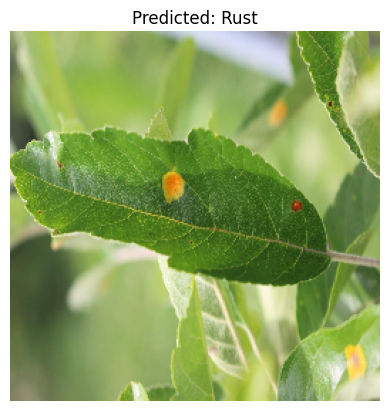

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()

In [22]:
model.save('tree lif leef leaf leaves fahhhhh.h5')